# Exposure database


In [1]:
# HIDE CODE
# Import necessary libraries
import gc
import logging
import os
import shutil
import warnings
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import pydeck as pdk
from tqdm import tqdm

# Set logging level
ox.settings.log_console = False
logging.getLogger("osmnx").setLevel(logging.ERROR)
# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
# Define the folder where the database will be stored
# TODO: We could set a .miraca folder as a default for all packages
Miraca_Exposure_Database_path = Path("~/miraca_exposure_database").expanduser()

This dictionary maps the names of European countries to their respective ISO 3166-1 alpha-2 codes. These codes are two-letter country codes defined in the ISO 3166-1 standard.The dictionary keys are country names (str) and values are their ISO 3166-1 alpha-2 codes (str).


In [3]:
EU_code = {
    "Albania": "AL",
    "Austria": "AT",
    "Belgium": "BE",
    "Bulgaria": "BG",
    "Croatia": "HR",
    "Cyprus": "CY",
    "Czechia": "CZ",
    "Denmark": "DK",
    "Estonia": "EE",
    "Finland": "FI",
    "France": "FR",
    "Germany": "DE",
    "Greece": "GR",
    "Hungary": "HU",
    "Iceland": "IS",
    "Ireland": "IE",
    "Italy": "IT",
    "Latvia": "LV",
    "Liechtenstein": "LI",
    "Lithuania": "LT",
    "Luxembourg": "LU",
    "Malta": "MT",
    "Montenegro": "ME",
    "Netherlands": "NL",
    "North_Macedonia": "MK",
    "Norway": "NO",
    "Poland": "PL",
    "Portugal": "PT",
    "Romania": "RO",
    "Serbia": "RS",
    "Slovakia": "SK",
    "Slovenia": "SI",
    "Spain": "ES",
    "Sweden": "SE",
    "Switzerland": "CH",
    "United_Kingdom": "UK",
    "Svalbard_and_Jan_Mayen": "SJ",
}

This dictionary maps the names of European countries to the cost from GEM. The dictionary keys are country names (str) and values are the GEM costs (float).


In [4]:
Gem_cost = {
    "Austria": 1454.26,
    "Belgium": 1349.35,
    "Bulgaria": 530.44,
    "Cyprus": 1221.97,
    "Czech_Republic": 1167.68,
    "Denmark": 2629.95,
    "Estonia": 953.19,
    "Finland": 2005.17,
    "France": 2225.00,
    "Germany": 1869.00,
    "Greece": 954.97,
    "Hungary": 534.89,
    "Ireland": 1640.27,
    "Italy": 1424.00,
    "Latvia": 937.17,
    "Lithuania": 962.09,
    "Luxembourg": 1418.66,
    "Malta": 931.83,
    "Netherlands": 1401.43,
    "Poland": 1440.02,
    "Portugal": 801.00,
    "Romania": 775.19,
    "Slovakia": 849.95,
    "Slovenia": 1110.72,
    "Spain": 747.60,
    "Sweden": 3528.85,
}

In [5]:
def map_network_to_code(network):
    """
    This function maps network names to shorter codes according to a predefined mapping.

    Arguments:
    network (str): The network name to be mapped.

    Returns:
    str: The corresponding code for the network, or the original network if not found in the mapping.
    """

    network_mapping = [
        ("Education", "Edu"),
        ("Healthcare", "Health"),
        ("Airports", "Airport"),
        ("Ports", "Port"),
        ("Roadway", "Road"),
        ("Railway", "Rail"),
        ("Telecommunication", "Telecom"),
        ("Electricity", "Elec"),
    ]

    for network_name, network_code in network_mapping:
        if network == network_name:
            return network_code
    return network

In [6]:
def get_network_tags(network):
    """
    This function takes an network type and returns the corresponding OpenStreetMap tags.

    Parameters:
    network (str): The type of network for which OSM tags are required.

    Returns:
    dict: A dictionary containing OSM tags associated with the specified network type.
    Returns an empty dictionary if the network type is not found.
    """

    network_tags = {
        "Education": {"amenity": "school"},
        "Healthcare": {"amenity": "hospital"},
        "Airports": {"aeroway": "aerodrome"},
        "Ports": {"waterway": "harbour", "landuse": "harbour", "man_made": "pier"},
        "Roadway": {
            "highway": [
                "motorway",
                "primary",
                "secondary",
                "tertiary",
                "motorway_link",
                "primary_link",
                "secondary_link",
                "tertiary_link",
            ]
        },
        "Railway": {"railway": "rail"},
        "Telecommunication": {"man_made": ["communications_tower", "mast"]},
        "Electricity": {
            "power": [
                "cable",
                "plant",
                "pole",
                "substation",
                "tower",
                "line",
                "minor_line",
            ]
        },
    }
    return network_tags.get(network)

In [7]:
def get_network_columns(network):
    """
    This function returns the list of columns associated with a particular network type.

    Parameters:
    network (str): The type of network for which column names are required.

    Returns:
    list: A list of column names associated with the specified network type.
    """
    network_columns = {
        "Education": [
            "name",
            "geometry",
            "amenity",
            "building:levels",
            "material",
            "height",
        ],
        "Healthcare": [
            "name",
            "geometry",
            "amenity",
            "emergency",
            "building:levels",
            "height",
            "beds",
        ],
        "Airports": [
            "name",
            "geometry",
            "aeroway",
            "ref",
            "int_name",
            "ele",
            "operator",
            "surface",
            "iata",
            "icao",
            "passengers",
            "landuse",
            "layer",
        ],
        "Ports": [
            "name",
            "geometry",
            "waterway",
            "man_made",
            "landuse",
            "ele",
            "surface",
            "tracktype",
            "material",
            "incline",
            "layer",
            "smoothness",
            "bridge",
            "oneway",
            "maxspeed",
            "maxweight",
        ],
        "Roadway": [
            "geometry",
            "highway",
            "name",
            "int_name",
            "int_ref",
            "maxspeed",
            "lanes",
            "oneway",
            "bridge",
            "sidewalk",
            "surface",
            "smoothness",
            "maxheight",
            "tunnel",
            "layer",
        ],
        "Railway": [
            "name",
            "geometry",
            "maxspeed",
            "voltage",
            "bridge",
            "layer",
            "tunnel",
            "cutting",
            "electrified",
            "usage",
            "embankment",
            "frequency",
            "tracks",
            "gauge",
        ],
        "Telecommunication": [
            "geometry",
            "man_made",
            "tower_type",
            "mast_type",
            "height",
            "ele",
            "material",
        ],
        "Electricity": [
            "name",
            "geometry",
            "power",
            "cables",
            "voltage",
            "location",
            "frequency",
            "type",
            "wires",
            "layer",
            "disused",
            "operator",
            "circuits",
            "usage",
        ],
    }
    return network_columns.get(network)

In [8]:
def replace_nan_values(gdf, column_name, value):
    """
    This function replaces NaN values in a specified column of a GeoDataFrame.

    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame to process.
    column_name (str): The name of the column in which to replace NaN values.
    value (str): The value to use as a replacement.

    Returns:
    GeoDataFrame: The processed GeoDataFrame.
    """
    gdf[column_name] = gdf[column_name].fillna(value)
    return gdf

## Visualize using pydeck


In [9]:
def visualize_with_pydeck(gdf, geom_type):
    """
    Visualizes geospatial data using Pydeck.

    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame containing the geospatial data to visualize.
    geom_type (str): The type of geometry ('Point', 'LineString', or 'Polygon').
    """

    # Extract latitude and longitude from the geometry column
    if geom_type == "Point":
        gdf["Longitude"], gdf["Latitude"] = gdf["geometry"].x, gdf["geometry"].y
    elif geom_type in ["LineString", "Polygon"]:
        gdf["Longitude"], gdf["Latitude"] = (
            gdf["geometry"].centroid.x,
            gdf["geometry"].centroid.y,
        )

    # Define a layer to display on a map
    layers = []
    if "Point" in geom_type:
        point_gdf = gdf[gdf["geometry"].geom_type == "Point"]
        point_layer = create_layer(point_gdf, "Point")
        layers.append(point_layer)
    if "LineString" in geom_type:
        line_gdf = gdf[gdf["geometry"].geom_type == "LineString"]
        line_layer = create_layer(line_gdf, "LineString")
        layers.append(line_layer)
    if "Polygon" in geom_type:
        polygon_gdf = gdf[gdf["geometry"].geom_type == "Polygon"]
        polygon_layer = create_layer(polygon_gdf, "Polygon")
        layers.append(polygon_layer)

    # Set the viewport location
    view_state = pdk.ViewState(
        latitude=gdf["Latitude"].mean(), longitude=gdf["Longitude"].mean(), zoom=6
    )

    # Render
    r = pdk.Deck(layers=layers, initial_view_state=view_state)
    html_filename = f"{network_type}_{geom_type}_{country}.html"
    r.to_html(html_filename)
    # display(IFrame(src=html_filename, width=1000, height=700))  # Display HTML inline in Jupyter Notebook
    return r

In [10]:
def get_color_based_on_attribute(row):
    attribute_value = row["bridge"]
    if attribute_value == "yes":
        return [255, 0, 0, 255]  # Red color for 'Value1'
    elif attribute_value == "no":
        return [0, 255, 0, 255]  # Green color for 'Value2'

In [11]:
def create_layer(gdf, geom_type):
    """
    Creates a Pydeck layer based on the geometry type.

    Parameters:
    gdf (GeoDataFrame): The GeoDataFrame containing the geospatial data to visualize.
    geom_type (str): The type of geometry ('Point', 'LineString', or 'Polygon').

    Returns:
    layer: A Pydeck layer.
    """
    # gdf['color'] = gdf.apply(get_color_based_on_attribute, axis=1)

    if geom_type == "Point":
        layer = pdk.Layer(
            "ScatterplotLayer",
            gdf,
            get_position=["Longitude", "Latitude"],
            get_radius=20,  # Radius is in meters
            get_fill_color=[161, 255, 10, 140],  # Set color and opacity
            pickable=True,
            auto_highlight=True,
            tooltip={"text": "{Country}, {Country_code}, {Geometry}"},
            opacity=0.8,
            stroked=True,
            filled=True,
            get_line_color=[100, 0, 0],
        )

    elif geom_type == "LineString":
        gdf["coordinates"] = gdf["geometry"].apply(lambda x: list(x.coords))
        layer = pdk.Layer(
            "PathLayer",
            gdf,
            get_path="coordinates",
            get_color=[255, 195, 0, 250],
            # get_color="color",  # Use the color column for the color
            get_width=200,
            pickable=True,
            auto_highlight=True,
            tooltip={"text": "{Country}, {Country_code}, {Geometry}"},
        )

    elif geom_type == "Polygon":
        gdf["coordinates"] = gdf["geometry"].apply(lambda x: x.exterior.coords[:])
        layer = pdk.Layer(
            "PolygonLayer",
            gdf,
            get_polygon="coordinates",
            get_fill_color=[10, 239, 255, 140],
            pickable=True,
            auto_highlight=True,
            tooltip={"text": "{Country}, {Country_code}, {Geometry}"},
            stroked=True,
            filled=True,
            get_line_color=[100, 0, 0],
        )

    return layer

## Select, download and save geospatial data using osmnx


In [12]:
def select_data_osmnx(country, network, database):
    """
    Fetches and processes geospatial data for a specific network type in a given country using OSMnx.

    Parameters:
    country (str): The name of the country for which data is being fetched.
    network (str): The type of network for which data is being fetched.
    database (str): The name of the database.

    Returns:
    GeoDataFrame or None: A GeoDataFrame containing the processed data if successful,
                          None if there was an error fetching the data.

    Raises:
    Exception: Re-raises any unexpected exceptions encountered during data retrieval.
    """

    try:
        # Get the abbreviation for the country
        country_abbr = EU_code.get(country, country)

        # Get the tags for the given network type
        tags = get_network_tags(network)

        if tags is None:
            print(f"No tags defined for network type '{network}'")
            return

        network_code = map_network_to_code(network)
        features = ox.features_from_place(country, tags=tags)

        # Define a dictionary that maps each network to the preferred geometry types
        network_geometry = {
            "Education": ["Point", "Polygon"],
            "Healthcare": ["Point", "Polygon"],
            "Airports": ["Point", "Polygon"],
            "Ports": ["Point", "Polygon"],
            "Roadway": ["LineString"],
            "Railway": ["LineString"],
            "Telecommunication": ["Point"],
            "Electricity": ["Point", "LineString"],
        }
        preferred_geometries = network_geometry.get(network)

        if preferred_geometries is None:
            print(f"No preferred geometries defined for network type '{network}'")
            return

        # Initialize gdf as an empty GeoDataFrame
        gdf = gpd.GeoDataFrame()

        # Keep only the features with the preferred geometries
        for geom_type in preferred_geometries:
            geom_features = features[features["geometry"].geom_type == geom_type]
            geom_features = geom_features.dropna(subset=["geometry"])

            if "geometry" not in geom_features.columns:
                geom_features["geometry"] = None

            columns = get_network_columns(network)

            # Explicitly create GeoDataFrame
            gdf = gpd.GeoDataFrame(geom_features, columns=columns)

            # Add columns for country name and abbreviation
            gdf["Country"] = country
            gdf["Country_code"] = country_abbr
            gdf["Geometry"] = geom_type

            # Set the CRS for the GeoDataFrame
            gdf.crs = "EPSG:4326"

            if network in ["Roadway", "Railway"]:
                # Call the function to replace NaN values
                gdf = replace_nan_values(gdf, "bridge", "no")
                gdf = replace_nan_values(gdf, "tunnel", "no")
                gdf = replace_nan_values(gdf, "layer", 0)
                # Convert 'layer' column to numeric, handling errors by setting them to NaN
                gdf["layer"] = pd.to_numeric(gdf["layer"], errors="coerce")

            if network == "Education" and country in Gem_cost:
                gdf["Cost_per_area"] = "{:.2f}".format(Gem_cost.get(country, np.nan))

            # Save to Geoparquet
            output_directory = os.path.join(
                Miraca_Exposure_Database_path, network, database, country_abbr
            )
            os.makedirs(output_directory, exist_ok=True)
            geom_type_to_letter = {
                "Point": "P",
                "LineString": "L",
                "Polygon": "Α",
                # Add more geometry types as needed
            }
            # Get the specific letter for the current geometry type
            geom_type_letter = geom_type_to_letter.get(geom_type, "")

            output_filename = os.path.join(
                output_directory,
                f"{network_code}{geom_type_letter}_{country_abbr}.parquet",
            )
            gdf.to_parquet(output_filename, engine="pyarrow", compression="snappy")
            plot_selected_features(gdf, country, network)

            # Pydeck visualization
            if geom_type in ["Point", "LineString", "Polygon"]:
                visualize_with_pydeck(gdf, geom_type)

        return gdf
    except Exception as e:
        error_message = str(e)
        if "No data elements in server response" in error_message:
            print(f"Error fetching data for {network}: {error_message}")
            return None
        else:
            raise

## Working with street network using osmnx


In [13]:
def get_street_network(country, network, database):
    """
    Download, model, and save a street network for a specified country and network type.

    Parameters:
    country (str): The name of the country for which the street network is to be modeled.
    network (str): The type of network for which the street network is to be modeled.
    database (str): The name of the database where the output files will be saved.

    """
    # Get the abbreviation for the country
    country_abbr = EU_code.get(country, country)

    # Get the tags for the given network type
    tags = get_network_tags(network)

    if tags is None:
        print(f"No tags defined for network type '{network}'")
        return

    network_code = map_network_to_code(network)

    # Define the types of roadways you want to include
    road_types = [
        "motorway",
        "primary",
        "secondary",
        "tertiary",
        "motorway_link",
        "primary_link",
        "secondary_link",
        "tertiary_link",
    ]

    # Download/model a street network for the specified country, including only specified road types
    features = ox.graph_from_place(
        country,
        network_type="drive",
        custom_filter='["highway"~"{}"]'.format("|".join(road_types)),
        retain_all=True,
        simplify=True,
    )

    # explore nodes and edges together in a single map
    gdf_nodes, gdf_edges = ox.graph_to_gdfs(features)
    m = gdf_edges.explore(color="skyblue", tiles="cartodbdarkmatter")
    gdf_nodes.explore(m=m, color="pink", marker_kwds={"radius": 6})

    place_boundaries = ox.geocode_to_gdf(country)
    place_boundaries.crs = "EPSG:4326"  # Set the CRS to WGS84
    fig, ax = plt.subplots(figsize=(5, 5))
    place_boundaries.plot(ax=ax, color="whitesmoke", edgecolor="grey")
    gdf_edges.plot(ax=ax, linewidth=1, edgecolor="black")
    gdf_nodes.plot(ax=ax, color="red", markersize=5)
    ax.axis("off")
    plt.show()

    # save graph as a shapefile
    output_directory = os.path.join(
        Miraca_Exposure_Database_path, network, database, country_abbr
    )
    os.makedirs(output_directory, exist_ok=True)
    output_filename = os.path.join(
        output_directory, f"{network_code}_{country_abbr}.shp"
    )
    ox.save_graph_shapefile(features, output_filename)

    # convert shp to parquet

    # Read the edges using GeoPandas
    gdf_L = gpd.read_file(os.path.join(output_filename, "edges.shp"))
    # Add columns for country name and abbreviation
    gdf_L["Country"] = country
    gdf_L["Country_code"] = country_abbr
    gdf_L["Geometry"] = "Linestring"
    # Define the path for the output GeoParquet file
    geoparquet_path = os.path.join(
        output_directory, f"{network_code}L_{country_abbr}.parquet"
    )
    # Write the GeoDataFrame to GeoParquet format
    gdf_L.to_parquet(geoparquet_path, index=None)

    # Read the nodes using GeoPandas
    gdf_P = gpd.read_file(os.path.join(output_filename, "nodes.shp"))
    # Add columns for country name and abbreviation
    gdf_P["Country"] = country
    gdf_P["Country_code"] = country_abbr
    gdf_P["Geometry"] = "Point"
    # Define the path for the output GeoParquet file
    geoparquet_path = os.path.join(
        output_directory, f"{network_code}P_{country_abbr}.parquet"
    )
    # Write the GeoDataFrame to GeoParquet format
    gdf_P.to_parquet(geoparquet_path, index=None)

    shutil.rmtree(output_filename)

## Plot selected network on a map


In [14]:
def plot_selected_features(geodataframe, country, network):
    """
    Plot selected features on a map.

    Parameters:
    geodataframe (GeoDataFrame): The GeoDataFrame containing the selected features to be plotted.
    country (str): The name of the country for which the features are being plotted.
    network (str): The type of network being plotted.

    Returns:
    None. The function directly displays the plot.
    """

    place_boundaries = ox.geocode_to_gdf(country)
    place_boundaries.crs = "EPSG:4326"  # Set the CRS to WGS84

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_title(f"{network} in {country}", fontsize=10, fontweight="bold")
    place_boundaries.plot(ax=ax, color="whitesmoke", edgecolor="grey")

    # Define a dictionary to map network types to colors and markers
    network_colors = {
        "Education": "green",
        "Healthcare": "red",
        "Airports": "purple",
        "Ports": "blue",
        "Roadway": "orange",
        "Railway": "black",
        "Telecommunication": "black",
        "Electricity": "black",
    }
    network_markers = {
        "Education": "o",
        "Healthcare": "v",
        "Airports": "s",
        "Ports": "p",
        "Roadway": "*",
        "Railway": "+",
        "Telecommunication": "h",
        "Electricity": "o",
    }

    # Loop over the geometries in the GeoDataFrame
    for geom_type in geodataframe["geometry"].geom_type.unique():
        # Filter the GeoDataFrame by the current geometry type
        gdf_geom = geodataframe[geodataframe["geometry"].geom_type == geom_type]

        # Get the color and marker for the current network type
        color = network_colors.get(network, "black")
        marker = network_markers.get(network, "o")

        # Plot the geometries with the corresponding color and marker
        gdf_geom.plot(ax=ax, color=color, marker=marker, markersize=5)

    ax.axis("off")
    plt.show()

In [15]:
# List of networks
network_list = [
    "Education",
    "Healthcare",
    "Airports",
    "Ports",
    "Railway",
    "Telecommunication",
    "Electricity",
]

Running for Railway in Spain


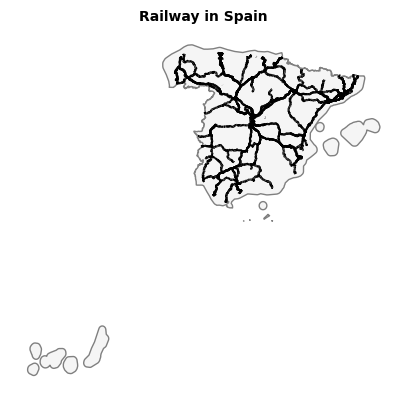

In [19]:
# Inside your loop for processing countries and networks, you can call this function
network_type = "Railway"
country = "Spain"
print(f"Running for {network_type} in {country}")
gdf = select_data_osmnx(country, network_type, "OSM")

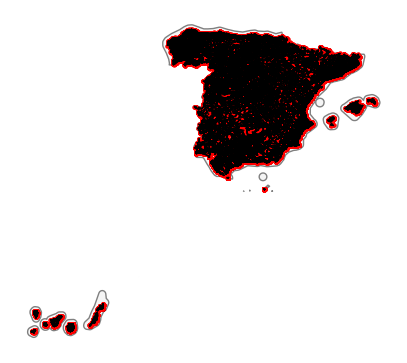

AttributeError: module 'osmnx' has no attribute 'save_graph_shapefile'

In [20]:
street_network = get_street_network(EU_code[country], "Roadway", "OSM")